In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
import scipy
int = np.vectorize(int)
cmap = plt.get_cmap('rainbow')

In [2]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
betx = 1.9065054393933862
alfx = 1.408226172730429
Nturn = np.array([128,256,512,1024])
ChaosPercent = 99.0
iTBTF = {}
iTBTB = {}
TBTF = {}
TBTB = {}
Npt = {}

NL_c = lattice[3].transverse_scale_c
x0 = betx**0.5*NL_c
x0 = np.array([-x0,x0])
y0 = [0,0]

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [3]:
for nturn in Nturn:
    iTBTF[nturn],TBTF[nturn] = impact.readTBT(nturn,ke,mass,freq)
    iTBTB[nturn],TBTB[nturn] = impact.readTBT(nturn+100000,ke,mass,freq)
    Npt[nturn] = len(iTBTB[nturn])
    
pData = impact.readParticleData(-111110,ke,mass,freq)
dist = scipy.stats.gaussian_kde(pData[:,[0,2]].transpose())

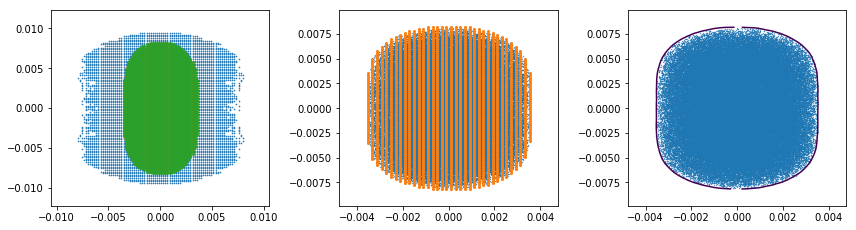

In [4]:
n0 = Nturn[0]
weight = dist([TBTF[n0][0,0,:],TBTF[n0][0,2,:]])
iCore = np.argwhere(weight > 500) # empirically found ...
iCore = iTBTF[n0][iCore]

iCoreTmp = np.in1d(iTBTF[n0],iCore)
xTmp = TBTF[n0][0,0,iCoreTmp]
yTmp = TBTF[n0][0,2,iCoreTmp]

grid = impact.data.dictClass()
grid.extent = [xTmp.min(),xTmp.max(),yTmp.min(),yTmp.max()]
grid.x, grid.y = np.mgrid[xTmp.min():xTmp.max():64j, yTmp.min():yTmp.max():64j]
grid.points = np.vstack([grid.x.ravel(), grid.y.ravel()])
grid.z = np.reshape(dist(grid.points).T, grid.x.shape)

plt.figure(figsize=(12,3.3))
plt.subplot(1,3,1)
plt.scatter(TBTF[n0][0,0,:],TBTF[n0][0,2,:],s=0.4)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,2)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,3)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.contour(grid.z.T, extent=grid.extent, levels=[800]);
plt.tight_layout()

# pData = None
# dist = None
# weight = None

In [5]:
X = {}
Y = {}
XB = {}
YB = {}

for n in range(len(Nturn)):
    nturn = Nturn[n]
    
    iBcore  = np.in1d(iTBTB[nturn],iCore)
    nptCore = np.count_nonzero(iBcore)
    #print(n,nptCore)
    
    X[nturn]=np.zeros((nturn,nptCore),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,nptCore),dtype=np.complex)
    XB[nturn]=TBTB[nturn][::-1,0,iBcore] - 1j*TBTB[nturn][::-1,1,iBcore]
    YB[nturn]=TBTB[nturn][::-1,2,iBcore] - 1j*TBTB[nturn][::-1,3,iBcore]
    #print(n,XB[nturn].shape)
    
    for m in range(n+1):
        mturn = Nturn[m]
        if m>0:
            iturn = Nturn[m-1]
        else:
            iturn = 0
        #print(iturn,mturn,nturn)    
        iBcore = np.in1d(iTBTF[mturn],iCore)
        #print(n,m,np.count_nonzero(iBcore))
        X[nturn][iturn:mturn,:] = TBTF[mturn][:,0,iBcore] - 1j*TBTF[mturn][:,1,iBcore]
        Y[nturn][iturn:mturn,:] = TBTF[mturn][:,2,iBcore] - 1j*TBTF[mturn][:,3,iBcore]
        
# iTBTF = None
# iTBTB = None
# TBTB = None
# TBTF = None

In [6]:
nturn = 256
iturn = 126
ipt = 100
print(X[nturn][iturn,ipt],XB[nturn][iturn,ipt])
print(X[nturn][iturn,ipt]-XB[nturn][iturn,ipt])

(0.0025326120178942794+0.004166072894748021j) (0.0025326120195909097+0.004166072894612599j)
(-1.6966302494869634e-12+1.3542205551386743e-13j)


In [7]:
iMax = {}
iMin = {}
Xdiff = {}
Ydiff = {}
Adiff = {}
XdiffLog = {}
YdiffLog = {}
AdiffLog = {}
XdiffSig = {}
YdiffSig = {}
AdiffSig = {}

for nturn in Nturn:
    Xdiff[nturn] = np.abs(XB[nturn]-X[nturn])**2
    Ydiff[nturn] = np.abs(YB[nturn]-Y[nturn])**2
    Adiff[nturn] = Xdiff[nturn] + Ydiff[nturn]
    Xdiff[nturn] = np.sqrt(np.sum(Xdiff[nturn],0)/nturn)
    Ydiff[nturn] = np.sqrt(np.sum(Ydiff[nturn],0)/nturn)
    Adiff[nturn] = np.sqrt(np.sum(Adiff[nturn],0)/nturn)
    XdiffLog[nturn] = np.log10(Xdiff[nturn])
    YdiffLog[nturn] = np.log10(Ydiff[nturn])
    AdiffLog[nturn] = np.log10(Adiff[nturn])
    AdiffSig[nturn] = 1.0/(1.0+np.exp(-AdiffLog[nturn]+np.percentile(AdiffLog[nturn],ChaosPercent)))
    XdiffSig[nturn] = 1.0/(1.0+np.exp(-XdiffLog[nturn]+np.percentile(XdiffLog[nturn],ChaosPercent)))
    YdiffSig[nturn] = 1.0/(1.0+np.exp(-YdiffLog[nturn]+np.percentile(YdiffLog[nturn],ChaosPercent)))
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

### Poincare

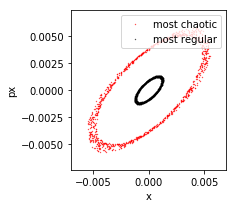

In [8]:
n = Nturn[-1]
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.A.png',dpi=180)

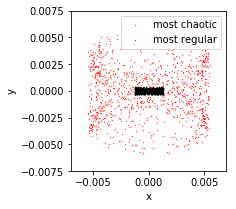

In [9]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.X.png',dpi=180)

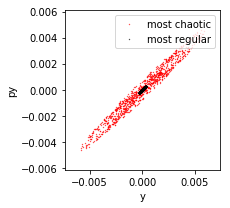

In [10]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.Y.png',dpi=180)

### Dynamic Aperture (Abs)

In [11]:
for n in Nturn:
    X[n]=X[n]*1.0e3
    Y[n]=Y[n]*1.0e3
x0 = x0*1.0e3

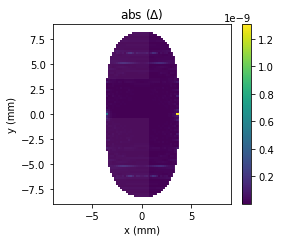

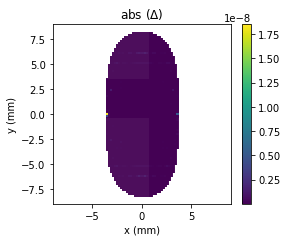

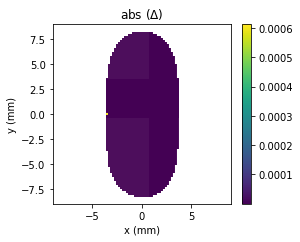

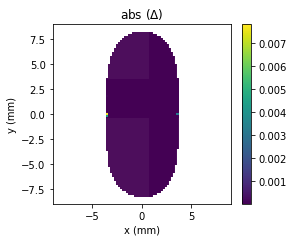

In [12]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'abs ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.Abs.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (Sig)

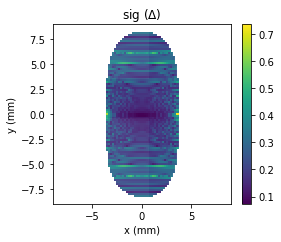

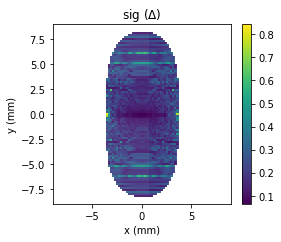

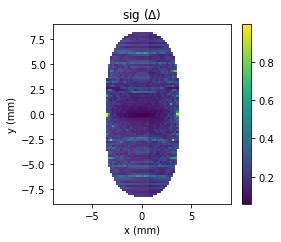

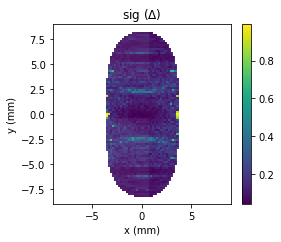

In [13]:
Adiff = AdiffSig
Xdiff = XdiffSig
Ydiff = YdiffSig

for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'sig ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.Sig.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (log)

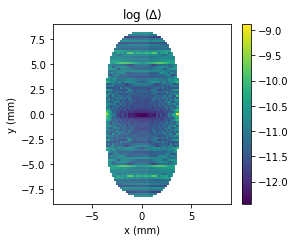

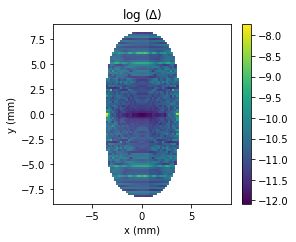

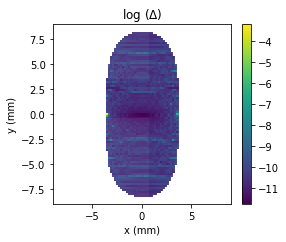

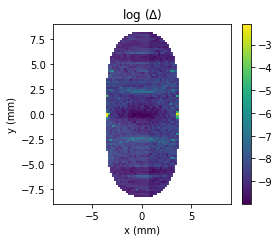

In [14]:
Adiff = AdiffLog
Xdiff = XdiffLog
Ydiff = YdiffLog

for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

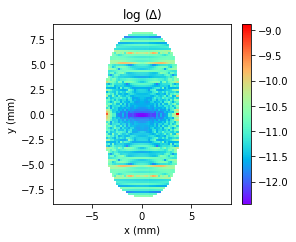

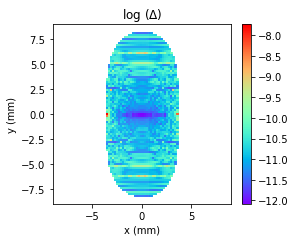

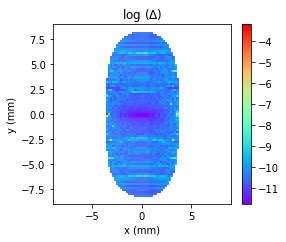

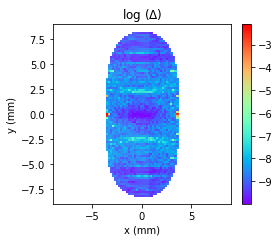

In [15]:
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s',cmap=cmap)
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

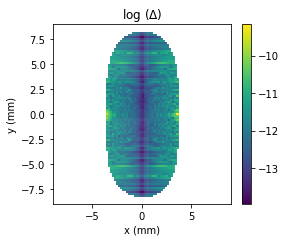

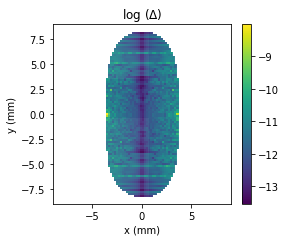

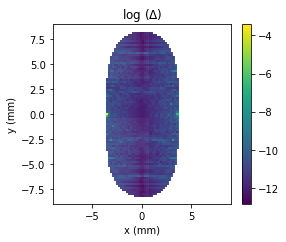

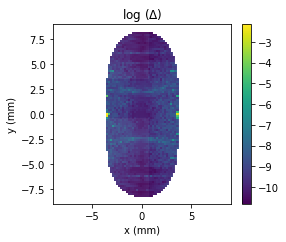

In [16]:
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Xdiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][1]]),np.real(Y[n][0,iMax[n][1]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.Log.X.'+str(nturn)+'.png',dpi=180)

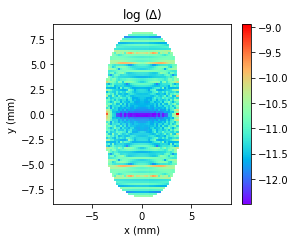

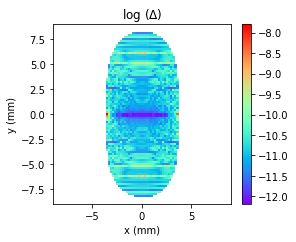

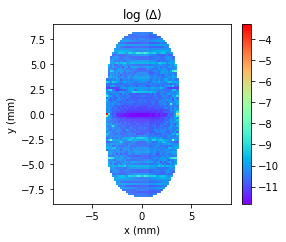

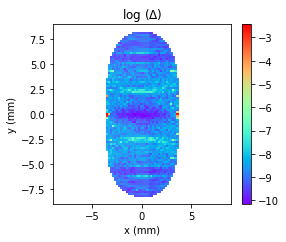

In [17]:
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Ydiff[n],s=1.6,marker='s',cmap=cmap)
#     plt.scatter(np.real(X[n][0,iMax[n][2]]),np.real(Y[n][0,iMax[n][2]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FB.DA.Log.Y.'+str(nturn)+'.png',dpi=180)